In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energy-consumption-prediction/Energy_consumption.csv


In [ ]:
"""
The model predicts the energy consumption of a house based on the following:
    Timestamp          
    Temperature        
    Humidity           
    SquareFootage      
    Occupancy            
    HVACUsage           
    LightingUsage      
    RenewableEnergy    
    DayOfWeek           
    Holiday             
    EnergyConsumption(target)  





https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction
"""

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler



data = pd.read_csv(r"/kaggle/input/energy-consumption-prediction/Energy_consumption.csv")

In [3]:
print(data.info())
print((data.describe()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Timestamp          1000 non-null   object 
 1   Temperature        1000 non-null   float64
 2   Humidity           1000 non-null   float64
 3   SquareFootage      1000 non-null   float64
 4   Occupancy          1000 non-null   int64  
 5   HVACUsage          1000 non-null   object 
 6   LightingUsage      1000 non-null   object 
 7   RenewableEnergy    1000 non-null   float64
 8   DayOfWeek          1000 non-null   object 
 9   Holiday            1000 non-null   object 
 10  EnergyConsumption  1000 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 86.1+ KB
None
       Temperature     Humidity  SquareFootage    Occupancy  RenewableEnergy  \
count  1000.000000  1000.000000    1000.000000  1000.000000      1000.000000   
mean     24.982026    45.395412    1500.05

In [4]:
print(data.head())

categorical = ['HVACUsage', 'LightingUsage', 'DayOfWeek', ' Holiday' ]

             Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
0  2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
1  2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2  2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
3  2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
4  2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

  HVACUsage LightingUsage  RenewableEnergy  DayOfWeek Holiday  \
0        On           Off         2.774699     Monday      No   
1        On            On        21.831384   Saturday      No   
2       Off           Off         6.764672     Sunday      No   
3       Off            On         8.623447  Wednesday      No   
4        On           Off         3.071969     Friday      No   

   EnergyConsumption  
0          75.364373  
1          83.401855  
2          78.270888  
3          56.519850  
4          70.811732  


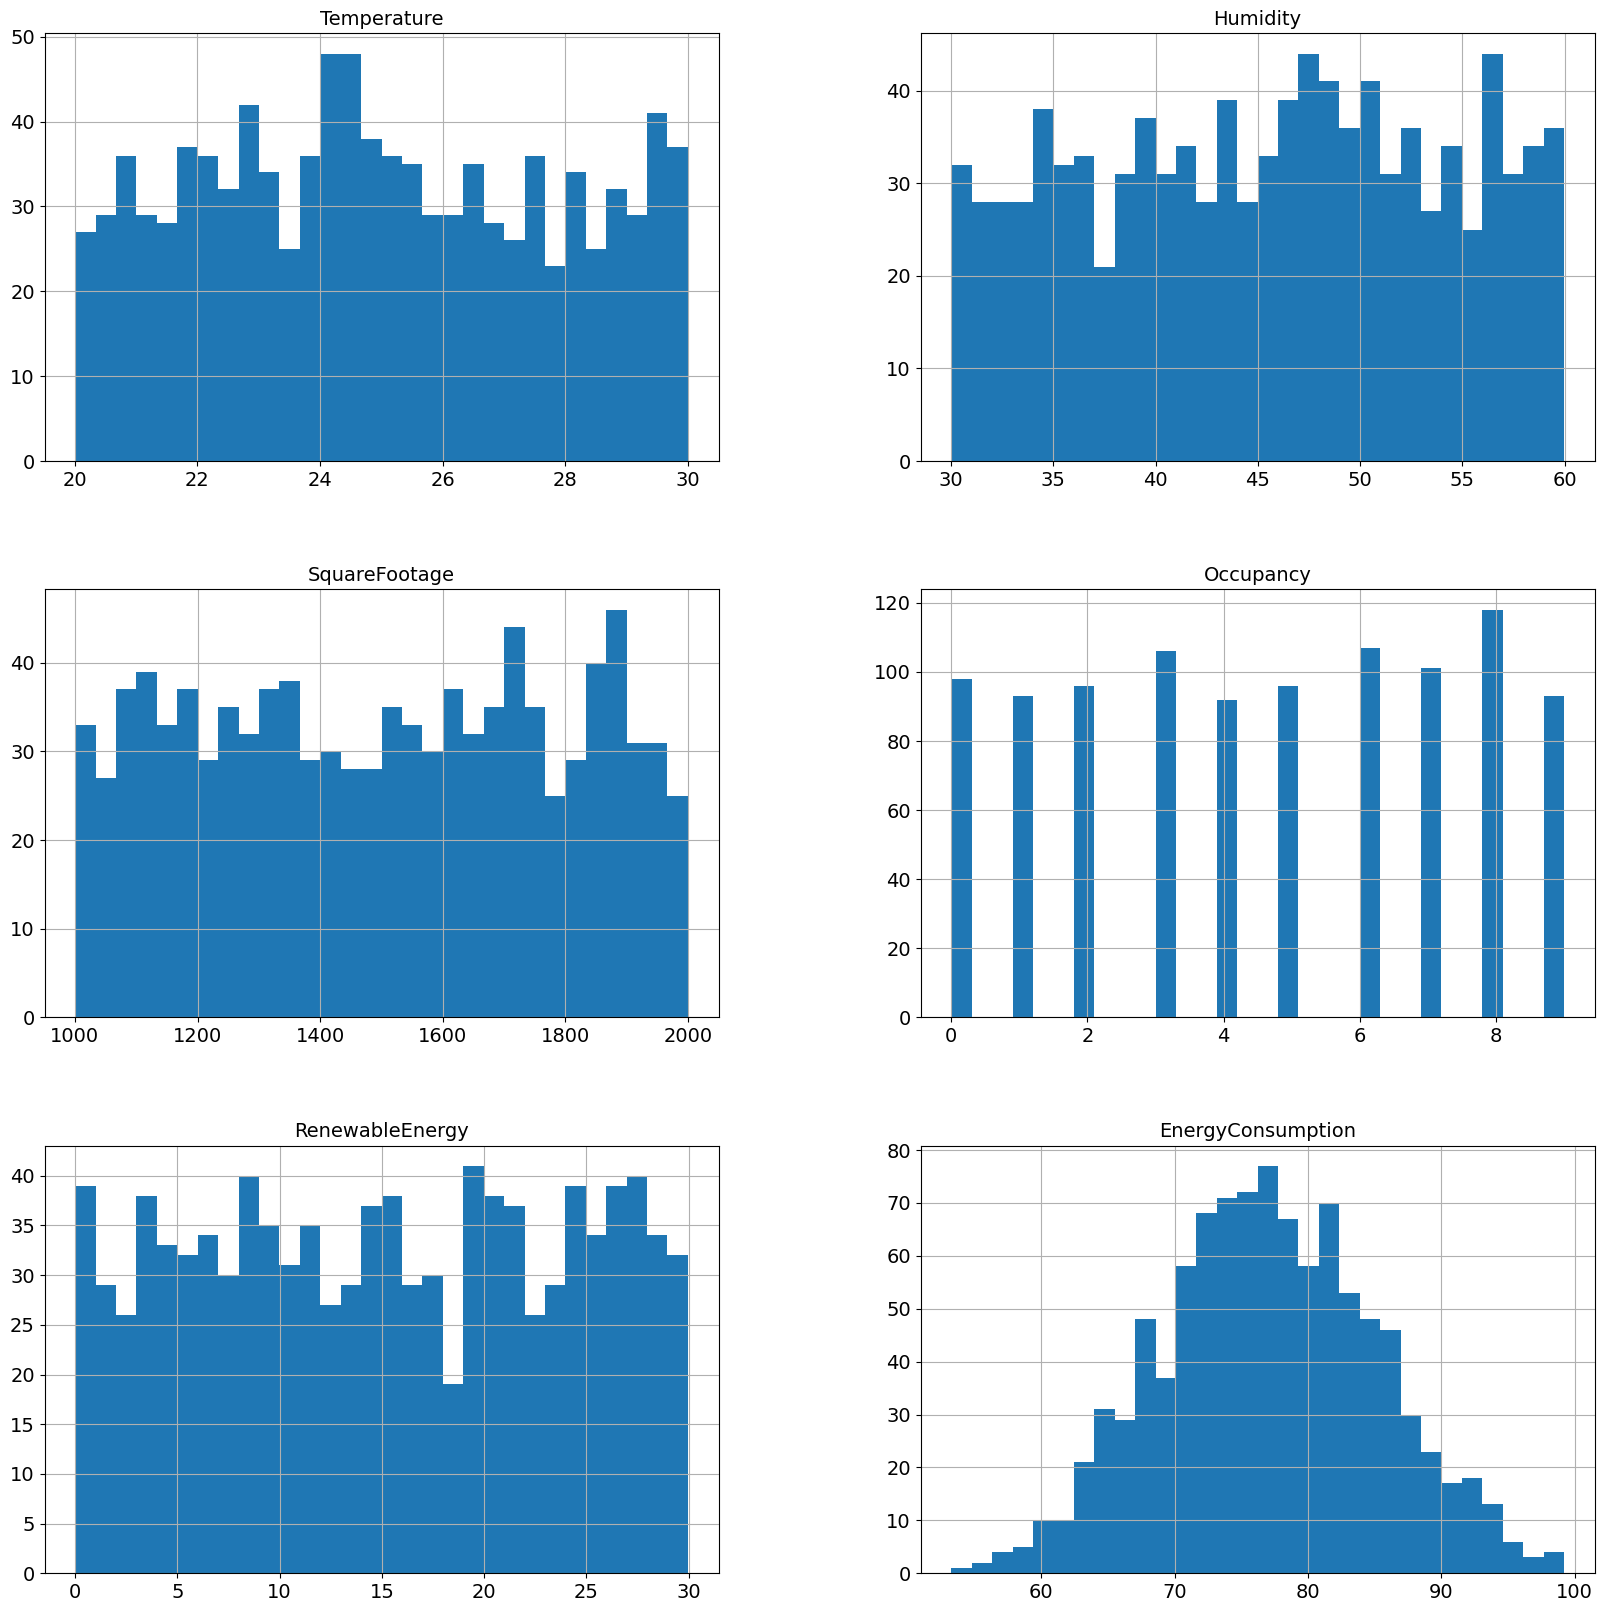

In [5]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14,titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

data.hist(bins=30, figsize=(20,20))
plt.show()



In [ ]:
#Encoding categorical data
data_1hot = pd.get_dummies(data, columns=['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday'], drop_first=True, dtype= 'int32')
data_1hot.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption,HVACUsage_On,LightingUsage_On,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Holiday_Yes
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,2.774699,75.364373,1,0,1,0,0,0,0,0,0
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,21.831384,83.401855,1,1,0,1,0,0,0,0,0
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,6.764672,78.270888,0,0,0,0,1,0,0,0,0
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,8.623447,56.519850,0,1,0,0,0,0,0,1,0
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,3.071969,70.811732,1,0,0,0,0,0,0,0,0


In [ ]:
# Convrting 'Timestamp' column to time datatype
data_1hot['Timestamp'] = pd.to_datetime(data_1hot['Timestamp'])
Dfinal = data_1hot.copy()
Dfinal['year'] = Dfinal['Timestamp'].dt.year
Dfinal['month'] = Dfinal['Timestamp'].dt.month
Dfinal = Dfinal.drop('Timestamp', axis=1)
Dfinal.head()
to_scale= ['Temperature','Humidity', 'SquareFootage','RenewableEnergy']

In [ ]:
#splitting
X = Dfinal.drop(['EnergyConsumption'], axis= 1)
Y = Dfinal['EnergyConsumption']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=43, shuffle=True) 
X_test

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,HVACUsage_On,LightingUsage_On,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,Holiday_Yes,year,month,day,hour,dayofweek
858,29.087373,37.304967,1315.389227,0,28.472737,1,1,0,0,0,0,1,0,0,2022,2,5,18,5
986,22.236948,31.936718,1718.346948,5,11.377115,0,1,0,0,0,0,0,1,1,2022,2,11,2,4
183,25.966790,38.733821,1616.558512,7,27.388245,1,1,0,0,0,1,0,0,0,2022,1,8,15,5
502,27.319955,48.887959,1709.051942,8,11.603709,0,0,0,0,0,0,1,0,0,2022,1,21,22,4
710,21.961216,54.989496,1947.495425,1,5.472511,1,1,1,0,0,0,0,0,0,2022,1,30,14,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,26.570001,43.330312,1126.062798,7,2.943403,0,1,0,0,0,1,0,0,0,2022,1,2,3,6
244,24.444100,44.292289,1706.911068,2,7.422181,0,0,0,0,0,1,0,0,0,2022,1,11,4,1
294,21.841437,57.528479,1214.575550,1,2.915925,0,0,0,0,1,0,0,0,1,2022,1,13,6,3
176,22.655824,54.163818,1086.475957,7,8.779763,0,1,0,0,0,0,0,1,1,2022,1,8,8,5


In [ ]:
# Custom training function to train the data and evaluate it
def train(Model, X =X, Y=Y,X_train = X_train, X_test = X_test, Y_train = Y_train, Y_test = Y_test):
    

    m = Model
    m.fit(X_train,Y_train)
    pred = m.predict(X_test)
    print('\t', Model)
    mae = mean_absolute_error(Y_test, pred)
    mse = mean_squared_error(Y_test, pred)
    r2 = r2_score(Y_test, pred)
    print(f"MSE: {mse}\n MAE: {mae}\n R2: {r2}")


In [ ]:
#training
train(KNeighborsRegressor(n_neighbors= 3),X,Y)
train(SVR(),X,Y) 

train(DecisionTreeRegressor(max_depth=3, random_state=44),X,Y)
train(RandomForestRegressor(n_estimators=150, random_state=44),X,Y)


	 KNeighborsRegressor(n_neighbors=3)
MSE: 73.77212837634748
 MAE: 6.713328367490189
 R2: -0.13685663659260783
	 SVR()
MSE: 64.82084796851866
 MAE: 6.3246514017853155
 R2: 0.00108600870735176
	 DecisionTreeRegressor(max_depth=3, random_state=44)
MSE: 31.53345487347393
 MAE: 4.508904159309639
 R2: 0.5140574328461952
	 RandomForestRegressor(n_estimators=150, random_state=44)
MSE: 26.79822705865953
 MAE: 4.200877619455429
 R2: 0.5870290995925707


In [ ]:
#Determine the best parameters for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=44)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
